# Contents:



*   [About Data](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
*   [EDA](#eda)
*   [Conclusion](#conc)
*   [Modelling](#mod)





# Libraries:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import ttest_ind, ks_2samp
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data:

In [2]:
#!unzip "/content/drive/MyDrive/bank-additional.zip" -d "/content/drive/MyDrive/bank-additional/"

In [3]:
bank = pd.read_csv('/content/drive/MyDrive/bank-additional/bank-additional/bank-additional-full.csv', sep = ';')

In [4]:
bank.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [5]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [6]:
bank.shape

(41188, 21)

<a name= 'eda'></a>
# EDA:

## Exploring Numerical Features:

In [7]:
num_df = bank.select_dtypes(include=np.number)


In [8]:
num_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


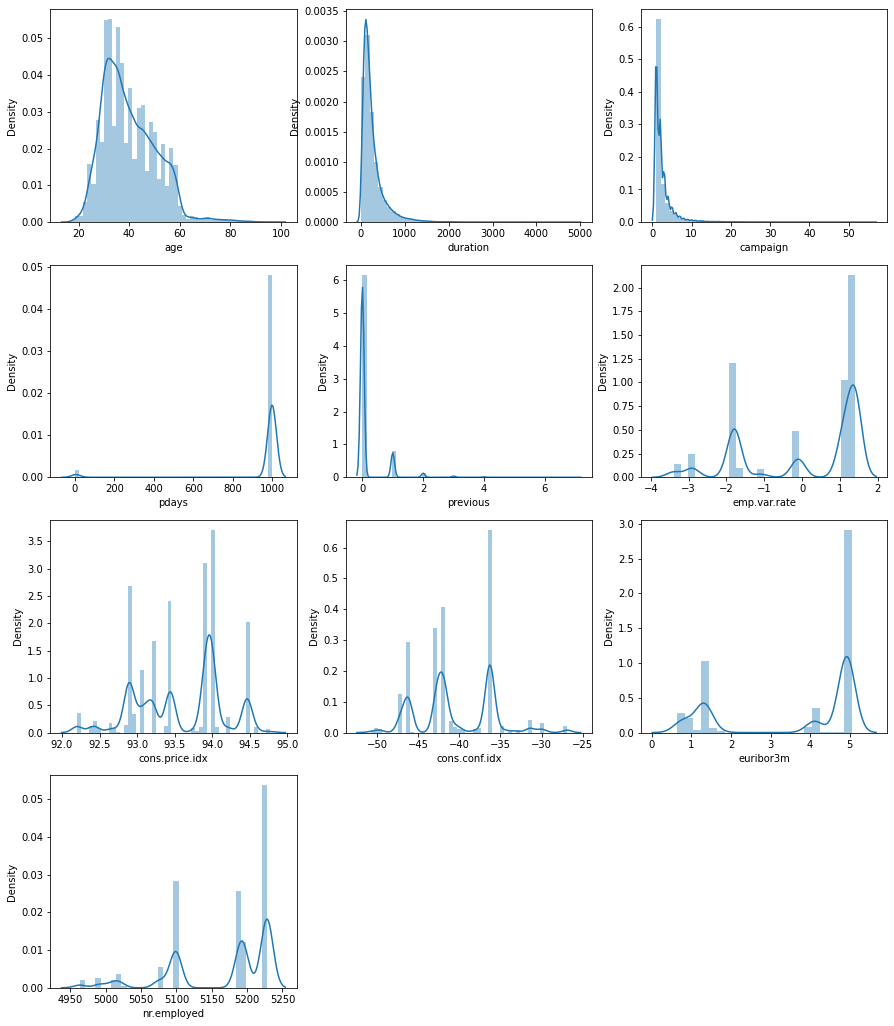

In [9]:
# plot distributions of numerical features
plt.figure(figsize=(15,18))
for index, col in enumerate(num_df.columns):
    plt.subplot(4, 3, index+1)
    sns.distplot(num_df[col])

## Exploring categorical features:

In [10]:
cat_df =  bank.select_dtypes(include='object')
cat_df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

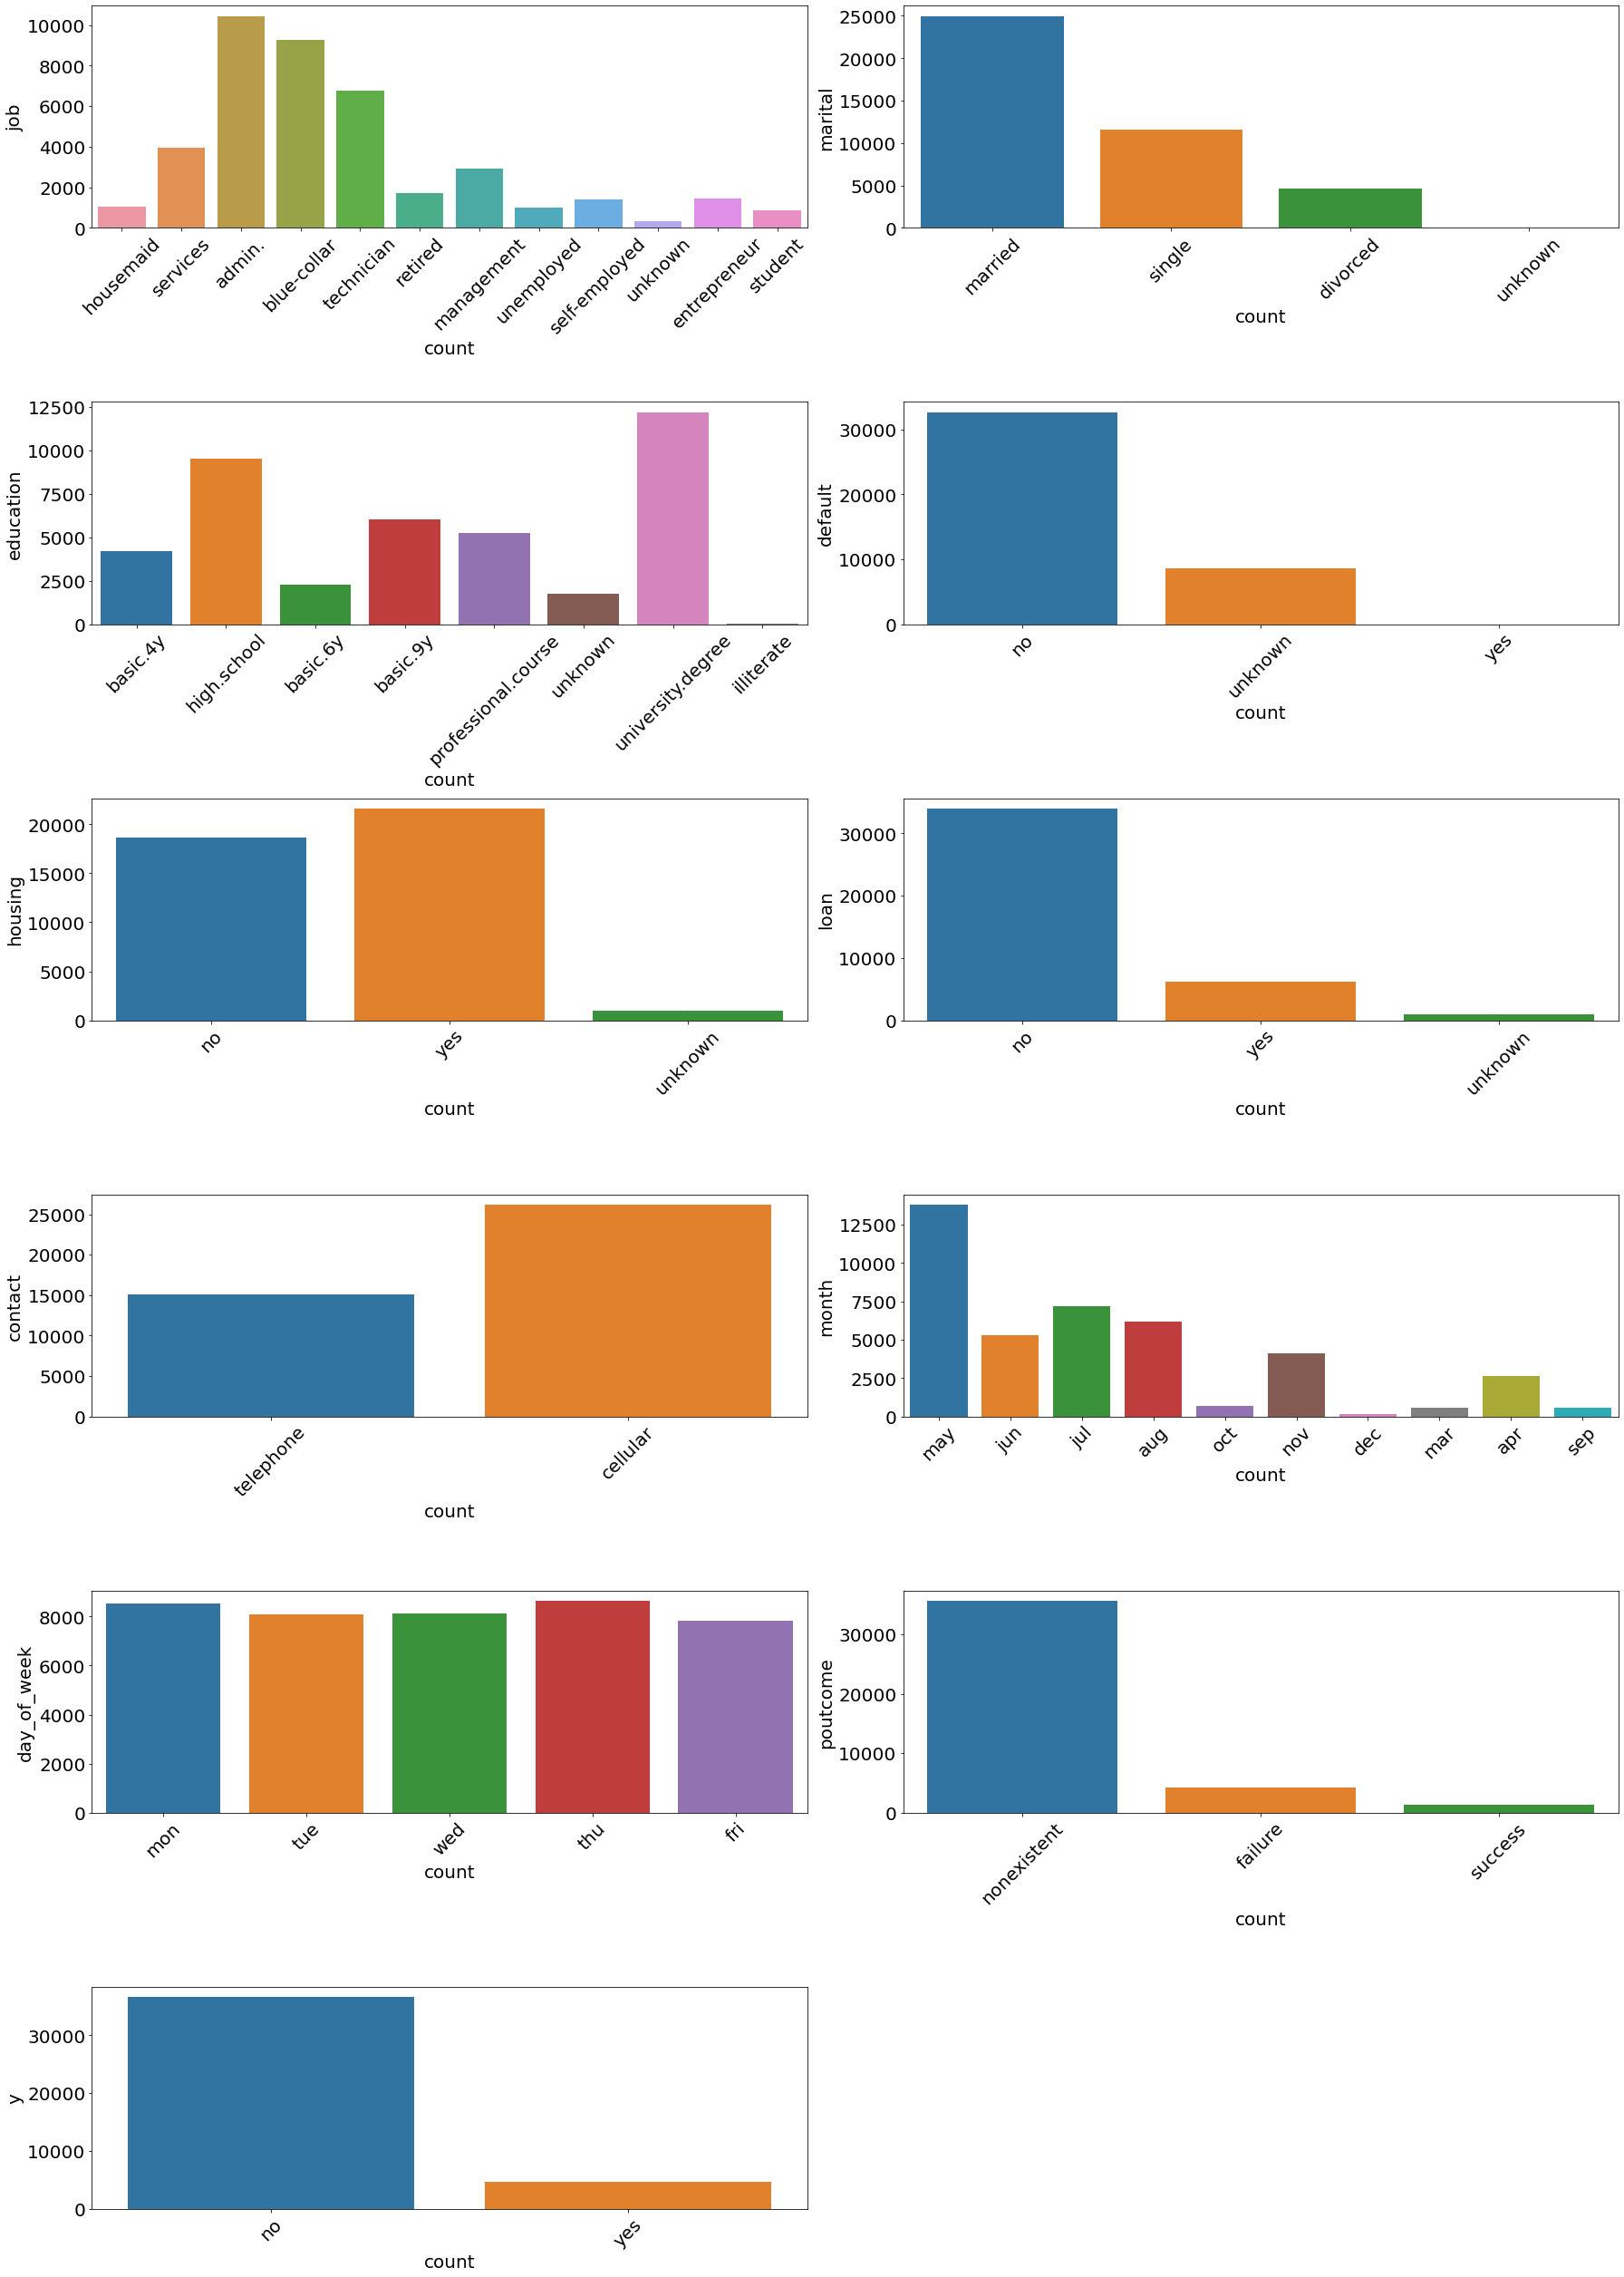

In [11]:
plt.figure(figsize=(25,35))
for index, col in enumerate(cat_df.columns):
    plt.subplot(6, 2, index+1)
    ax = sns.countplot(cat_df[col])
    ax.set_xlabel("count", fontsize=20)
    ax.set_ylabel(col, fontsize=20)
    ax.tick_params(labelsize=20)
    plt.xticks(rotation = 45)
    plt.tight_layout()

In [12]:
bank.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [13]:
bank.y.value_counts(normalize = True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

## Numerical Feature Impact

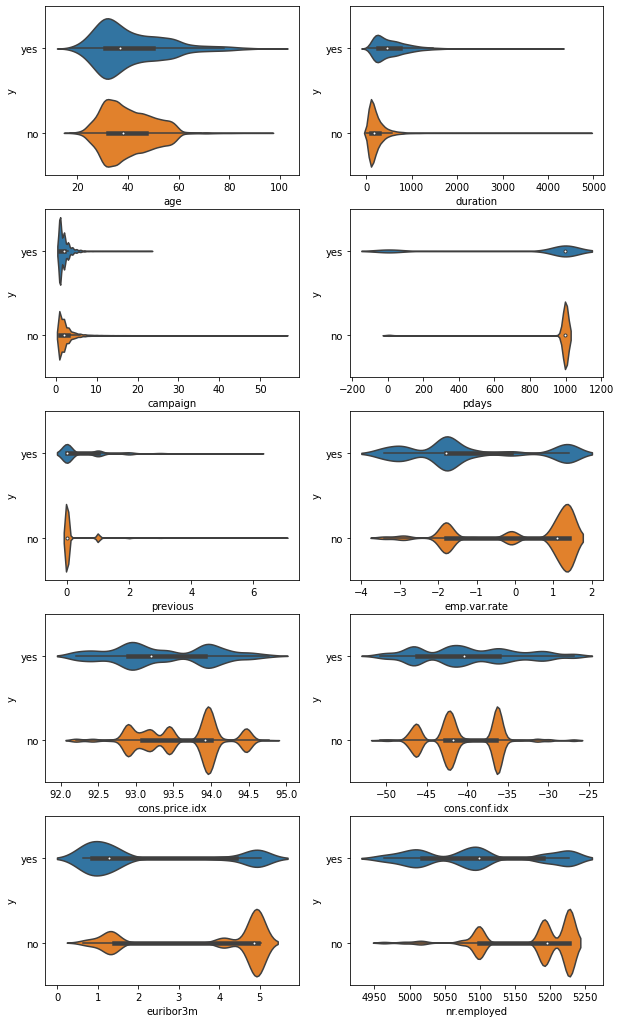

In [14]:
plt.figure(figsize=(10,18))
for index, col in enumerate(num_df):
    plt.subplot(5, 2, index+1)
    sns.violinplot(x=col, y="y", data=bank, 
                   order=["yes", "no"]);

### Checking significance of variation between yes and no:

#### 1) Mean:

In [15]:
def test_means(data, col):
    yes_mask = data["y"] == "yes"
    values_yes = data[col][yes_mask]
    values_no = data[col][~yes_mask]
    mean_yes = values_yes.mean()
    mean_no = values_no.mean()
    ttest_res = ttest_ind(values_yes, values_no)
    return [col, mean_yes, mean_no, round(ttest_res[0], 4), round(ttest_res[1],4)]

In [16]:
# defne pandas dataframe, in which values should be flled
test_df = pd.DataFrame(columns=["column", "mean yes", \
                                "mean no", "ttest stat", \
                                "ttest pval"])

for index, col in enumerate(num_df):
    test_df.loc[index] = test_means(bank, col)

In [17]:
test_df

,column,mean yes,mean no,ttest stat,ttest pval
0,age,40.913147,39.911185,6.1721,0.0
1,duration,553.191164,220.844807,89.9672,0.0
2,campaign,2.051724,2.633085,-13.4965,0.0
3,pdays,792.035560,984.113878,-69.7221,0.0
4,previous,0.492672,0.132374,48.0027,0.0
5,emp.var.rate,-1.233448,0.248875,-63.4337,0.0
6,cons.price.idx,93.354386,93.603757,-27.9032,0.0
7,cons.conf.idx,-39.789784,-40.593097,11.1539,0.0
8,euribor3m,2.123135,3.811491,-65.6466,0.0
9,nr.employed,5095.115991,5176.166600,-76.9845,0.0


#### 2) Distribution:

In [18]:
def test_ks(data, col):
    yes_mask = data["y"] == "yes"
    values_yes = data[col][yes_mask]
    values_no = data[col][~yes_mask]
    kstest_res = ks_2samp(values_yes, values_no)
    return [col, round(kstest_res[0], 4), round(kstest_res[1],4)]

In [19]:
test_df_2 = pd.DataFrame(columns=["column", "ks stat", "ks pval"])

for index, col in enumerate(num_df):
    test_df_2.loc[index] = test_ks(bank, col)

In [20]:
test_df_2

,column,ks stat,ks pval
0,age,0.0861,0.0
1,duration,0.4641,0.0
2,campaign,0.0808,0.0
3,pdays,0.1934,0.0
4,previous,0.2102,0.0
5,emp.var.rate,0.4324,0.0
6,cons.price.idx,0.2281,0.0
7,cons.conf.idx,0.1998,0.0
8,euribor3m,0.4326,0.0
9,nr.employed,0.4324,0.0


## Spiltting numerical features into two groups, one for campaign and another for financial attributes.

In [21]:
# create arrays containing campaign and fnancial columns
campaign_columns = ["age", "duration", "campaign", "previous"]
financial_columns = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m"]

<Figure size 720x720 with 0 Axes>

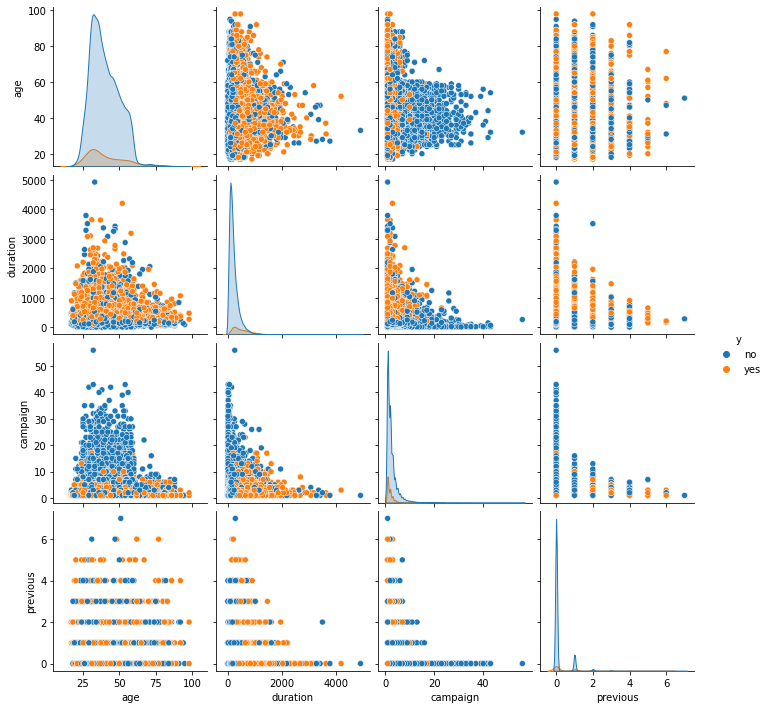

In [22]:
# create pairplot between campaign columns
plot_data = bank[campaign_columns + ["y"]]
plt.figure(figsize=(10,10))
sns.pairplot(plot_data, hue="y");

In [23]:
bank[bank.previous == 0].y.value_counts()

no     32422
yes     3141
Name: y, dtype: int64

In [24]:
bank.groupby(['previous', 'y'])['y'].count()

previous  y  
0         no     32422
          yes     3141
1         no      3594
          yes      967
2         no       404
          yes      350
3         no        88
          yes      128
4         no        32
          yes       38
5         no         5
          yes       13
6         no         2
          yes        3
7         no         1
Name: y, dtype: int64

<Figure size 720x720 with 0 Axes>

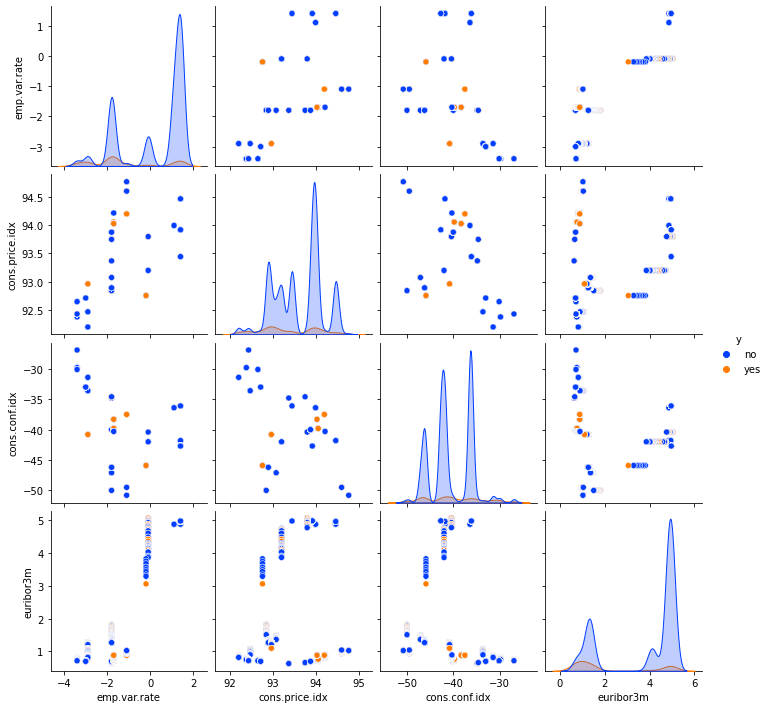

In [25]:
plot_data = bank[financial_columns + ["y"]]
plt.figure(figsize=(10,10))
sns.pairplot(plot_data, hue="y", palette="bright");

In [26]:
# create mask for successful calls
successful_calls = bank.y == "yes"
# plot correlation matrix for successful calls
plot_data = bank[campaign_columns + financial_columns][successful_calls]
successful_corr = plot_data.corr()
successful_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m
age,1.00,-0.06,-0.01,0.07,-0.08,-0.02,0.14,-0.09
duration,-0.06,1.00,0.16,-0.23,0.50,0.24,-0.14,0.50
campaign,-0.01,0.16,1.00,-0.10,0.22,0.12,-0.04,0.21
previous,0.07,-0.23,-0.10,1.00,-0.28,0.09,0.13,-0.39
emp.var.rate,-0.08,0.50,0.22,-0.28,1.00,0.66,-0.27,0.93
cons.price.idx,-0.02,0.24,0.12,0.09,0.66,1.00,-0.33,0.41
cons.conf.idx,0.14,-0.14,-0.04,0.13,-0.27,-0.33,1.00,-0.12
euribor3m,-0.09,0.50,0.21,-0.39,0.93,0.41,-0.12,1.00


In [27]:
# plot correlation matrix for unsuccessful calls
plot_data = bank[campaign_columns + financial_columns][~successful_calls]
unsuccessful_corr = plot_data.corr()
unsuccessful_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m
age,1.00,0.00,0.01,-0.00,0.03,0.01,0.12,0.04
duration,0.00,1.00,-0.08,-0.00,0.00,0.02,0.00,0.01
campaign,0.01,-0.08,1.00,-0.07,0.13,0.12,-0.01,0.12
previous,-0.00,-0.00,-0.07,1.00,-0.42,-0.27,-0.14,-0.44
emp.var.rate,0.03,0.00,0.13,-0.42,1.00,0.80,0.32,0.98
cons.price.idx,0.01,0.02,0.12,-0.27,0.80,1.00,0.15,0.73
cons.conf.idx,0.12,0.00,-0.01,-0.14,0.32,0.15,1.00,0.39
euribor3m,0.04,0.01,0.12,-0.44,0.98,0.73,0.39,1.00


<a name = 'conc'> </a>
# Conclusions:



*   We see some variation in distribution for some numerical features between people who respondes with yes and those responded with no.
*   We found the difference in mean for numerical feature between yes and no cases statistically significant.
*   We found significant difference in distribution between yes and no cases.
*   The correlation between euribor3m and emp.var.rate for both successful calls(.93) and unsuccessful ones (.98).


<a name = 'mod'></a>
# Modelling:

In [28]:
# create a feature matrix
columns = ["duration", "campaign", "pdays", "cons.price.idx", \
           "cons.conf.idx", "euribor3m"]
X = bank[columns]
X = sm.add_constant(X)
X.head()

,const,duration,campaign,pdays,cons.price.idx,cons.conf.idx,euribor3m
0,1.0,261,1,999,93.994,-36.4,4.857
1,1.0,149,1,999,93.994,-36.4,4.857
2,1.0,226,1,999,93.994,-36.4,4.857
3,1.0,151,1,999,93.994,-36.4,4.857
4,1.0,307,1,999,93.994,-36.4,4.857


In [29]:
y = np.where(bank["y"] == "yes", 1 ,0)

In [30]:
# defne and ft model
full_logistic_regression_model = sm.Logit(y, X)
result = full_logistic_regression_model.fit(maxiter=500)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.222140
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41181
Method:                           MLE   Df Model:                            6
Date:                Mon, 18 Jul 2022   Pseudo R-squ.:                  0.3690
Time:                        16:34:58   Log-Likelihood:                -9149.5
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -43.1379      3.524    -12.240      0.000     -50.046     -36.230
duration         